In [1]:
# Install required libraries
!pip install tensorflow opencv-python Pillow scipy scikit-learn matplotlib seaborn shutil glob

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [12]:
# Paths to original and augmented datasets
original_data_dir = 'C:/Users/HP/Downloads/dataset/Original Dataset/Original Dataset/'
augmented_data_dir = 'C:/Users/HP/Downloads/dataset/Augmented Dataset/Augmented Dataset/'

# Function to get image paths and labels
def get_image_paths_and_labels(data_dir):
    image_paths = glob(os.path.join(data_dir, '*/*.jpg'))
    labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]
    return image_paths, labels

In [13]:
# Get original and augmented data
original_paths, original_labels = get_image_paths_and_labels(original_data_dir)
augmented_paths, augmented_labels = get_image_paths_and_labels(augmented_data_dir)

# Combine original and augmented data
all_paths = original_paths + augmented_paths
all_labels = original_labels + augmented_labels

# Create a DataFrame to facilitate stratified split
data_df = pd.DataFrame({'path': all_paths, 'label': all_labels})

In [14]:
# Stratified split to maintain class distribution
train_df, val_df = train_test_split(data_df, test_size=0.2, stratify=data_df['label'], random_state=42)

# Data augmentation and data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label', target_size=(224, 224), batch_size=16, class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label', target_size=(224, 224), batch_size=16, class_mode='categorical'
)

# Define model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

# Save the final model
model.save('final_model.keras')

Found 17261 validated image filenames belonging to 10 classes.
Found 4316 validated image filenames belonging to 10 classes.


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2037s 2s/step - accuracy: 0.5608 - loss: 1.2718 - val_accuracy: 0.7055 - val_loss: 1.0545 - learning_rate: 1.0000e-04
Epoch 2/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1986s 2s/step - accuracy: 0.7448 - loss: 0.7046 - val_accuracy: 0.8026 - val_loss: 0.5456 - learning_rate: 1.0000e-04
Epoch 3/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2025s 2s/step - accuracy: 0.7848 - loss: 0.5746 - val_accuracy: 0.8214 - val_loss: 0.4717 - learning_rate: 1.0000e-04
Epoch 4/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1976s 2s/step - accuracy: 0.8029 - loss: 0.5241 - val_accuracy: 0.8237 - val_loss: 0.4746 - learning_rate: 1.0000e-04
Epoch 5/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1974s 2s/step - accuracy: 0.8187 - loss: 0.4840 - val_accuracy: 0.8364 - val_loss: 0.4449 - learning_rate: 1.0000e-04
Epoch 6/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1957s 2s/step - accuracy: 0.8238 - loss: 0.4600 - val_accuracy: 0.7790 - val_loss: 0.6060 - learning_rate: 1.0000e-04
Epoch 7/10
1079/1079 ━━━━━━━━━━━━━━━━━━━

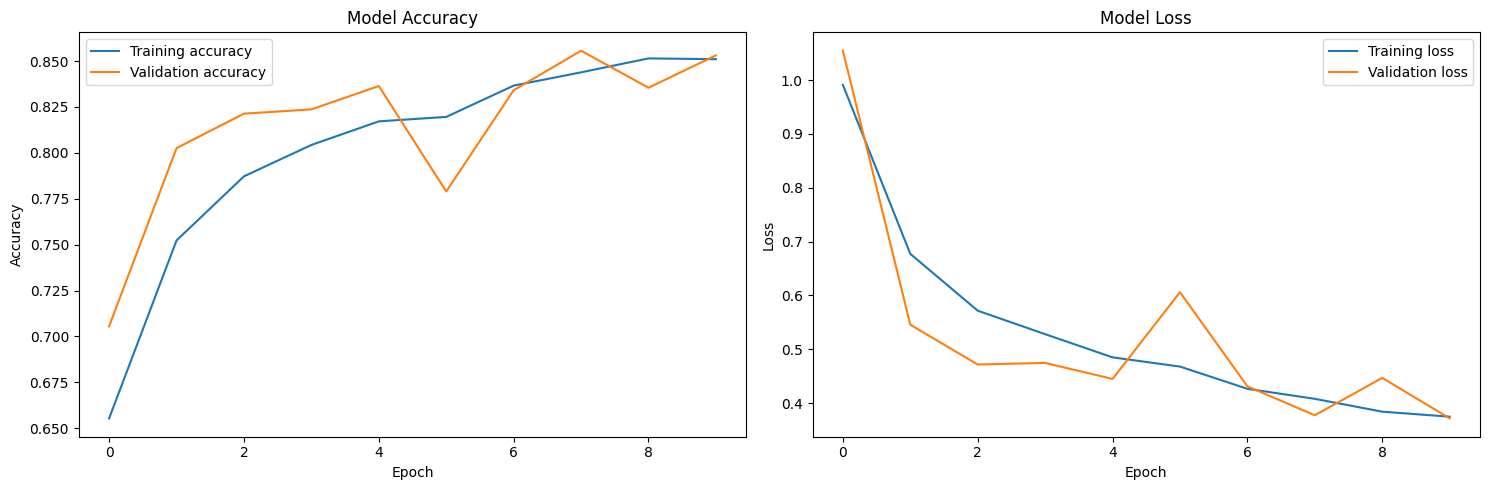

In [15]:
# Plot training metrics
def plot_training_metrics(history):
    metrics = ['accuracy', 'loss']
    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_metrics(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

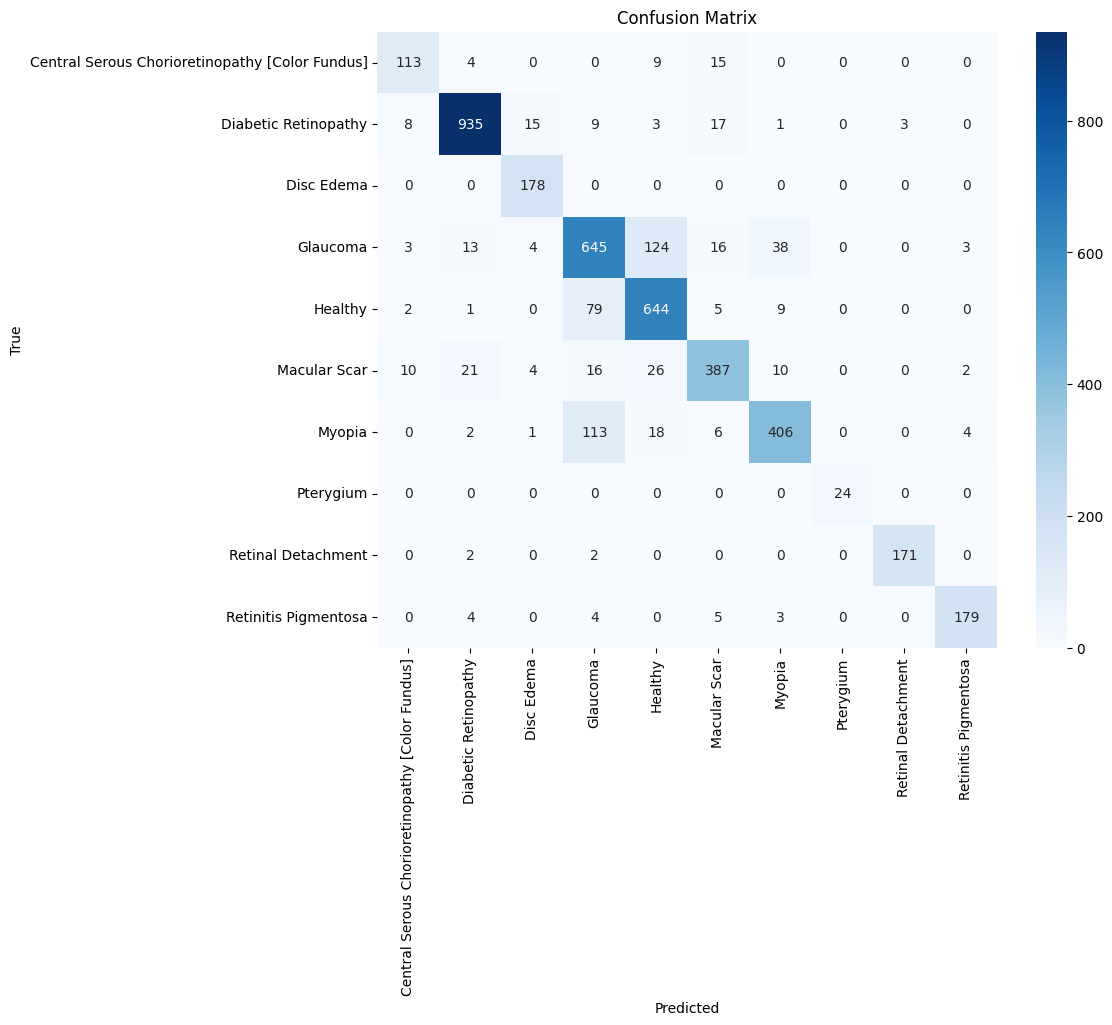

In [16]:
# Plot confusion matrix
def plot_confusion_matrix(model, val_generator, class_names):
    y_pred = []
    y_true = []
    for i in range(len(val_generator)):
        x_batch, y_batch = val_generator[i]
        pred = model.predict(x_batch)
        y_pred.extend(np.argmax(pred, axis=1))
        y_true.extend(np.argmax(y_batch, axis=1))
        if i == val_generator.samples // val_generator.batch_size:
            break
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, val_generator, list(train_generator.class_indices.keys()))

In [ ]:
# Print classification report
def print_classification_report(model, val_generator, class_names):
    y_pred = []
    y_true = []
    for i in range(len(val_generator)):
        x_batch, y_batch = val_generator[i]
        pred = model.predict(x_batch)
        y_pred.extend(np.argmax(pred, axis=1))
        y_true.extend(np.argmax(y_batch, axis=1))
        if i == val_generator.samples // val_generator.batch_size:
            break
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

print_classification_report(model, val_generator, list(train_generator.class_indices.keys()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Dataset distribution plot
def plot_dataset_distribution(original_paths, augmented_paths):
    original_counts = pd.Series([os.path.basename(os.path.dirname(path)) for path in original_paths]).value_counts().sort_index()
    augmented_counts = pd.Series([os.path.basename(os.path.dirname(path)) for path in augmented_paths]).value_counts().sort_index()
    counts_df = pd.DataFrame({'Original Count': original_counts, 'Augmented Count': augmented_counts}).fillna(0).astype(int)
    counts_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Distribution of Images in Each Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

plot_dataset_distribution(original_paths, augmented_paths)